In [46]:
import wandb
from datetime import datetime

In [47]:
lr = 1e-3
batch_size = 32
wd = 5e-5
pos_weight = 20
mse_weight = 500  # relative to classification error
image_size = 256
# backbone="resnet50"
vertical_type = "axial"
milestones=[10,20,30,40]
epochs=40

In [48]:
wandb_entity='longyi'
model_name = "effseg"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "mse_weight" : mse_weight,
    "image_size" : image_size,
})
wandb.run.name = f'axial_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_segmentation_deeplab_192205'

In [22]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, f"train_axial_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_axial_labels")

In [25]:
df = pd.read_csv(os.path.join(DATA_DIR, 'axial_segmentation_index_table.csv')).set_index('UID')
print(len(df))
df.head()

29832


,axial_index
UID,
1.2.826.0.1.3680043.10633,0
1.2.826.0.1.3680043.10633,1
1.2.826.0.1.3680043.10633,2
1.2.826.0.1.3680043.10633,3
1.2.826.0.1.3680043.10633,4


## Dataset


In [26]:
class SegDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name

        index = int(s[f"axial_index"])

        slice_img = Image.open(os.path.join(self.image_dir, UID, f"{index}.jpeg"))
        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{index}.png"))

        if self.transform:
            slice_img, label_img= self.transform(slice_img, label_img)

        return slice_img, label_img


512 512


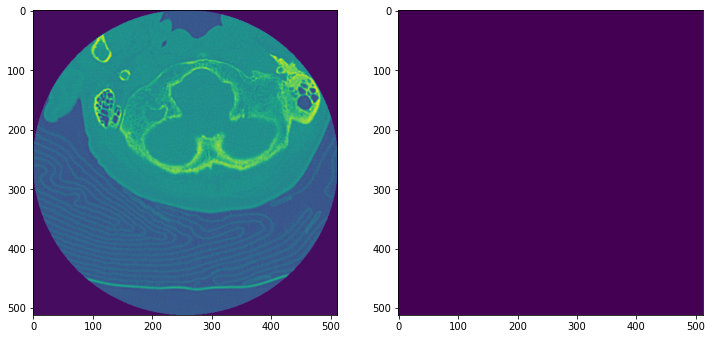

In [27]:
train_df, val_df = train_test_split(df, test_size=0.2)

train_dataset = SegDataset(train_df, IMAGES_DIR, LABEL_DIR)

slice, label = train_dataset[150]
print(slice.width, slice.height)

_, axs = plt.subplots(1, 2, figsize=(12, 12))
axs[0].imshow(slice)
axs[1].imshow(label)

## Transform

In [10]:
# aug = A.Compose([
#     A.ShiftScaleRotate(p=1, rotate_limit=45),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Resize(256, 256),
# ])

# augmented = aug(image=np.asarray(slice), masks=[np.asarray(label), np.asarray(indication)])

# image_heavy = augmented['image']
# mask_heavy = augmented['masks']

# _, axs = plt.subplots(1, 3)
# axs[0].imshow(image_heavy)
# axs[1].imshow(mask_heavy[0])
# axs[2].imshow(mask_heavy[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
tensor(-0.9216) tensor(0.7725)
tensor(0.) tensor(0.)


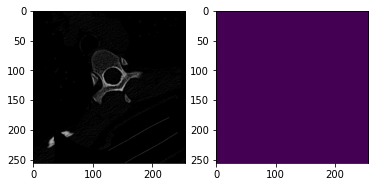

In [29]:
class DataTransform(nn.Module):
    def __init__(self, image_size, train=True):
        super().__init__()

        self.image_size = image_size

        if train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, rotate_limit=45),
                A.RandomBrightnessContrast(p=0.5),
                A.Resize(image_size, image_size),
                ToTensorV2(p=1),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(image_size, image_size),
                ToTensorV2(p=1),
            ])

        self.normalize = T.Normalize(255 * 0.5, 255 * 0.5)

    def forward(self, x, label):
        augmented = self.transform(image=np.asarray(x), mask=np.asarray(label) / 256.)
        x, label= augmented['image'],  augmented['mask']

        x = self.normalize(x.float())

        return torch.cat((x, x, x), dim=0), label.unsqueeze(0).float()


train_dataset = SegDataset(train_df, IMAGES_DIR, LABEL_DIR, DataTransform(image_size))
val_dataset = SegDataset(val_df, IMAGES_DIR, LABEL_DIR, DataTransform(image_size, train=False))
slice, label = train_dataset[700]
print(slice.shape, label.shape)
print(slice.min(), slice.max())
print(label.min(), label.max())

_, axs = plt.subplots(1, 2)
axs[0].imshow(slice.permute(1, 2, 0).squeeze())
axs[1].imshow(label.squeeze())

## Model

In [30]:
from efficientunet import *

# model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=True)

In [31]:
# model

In [32]:
def get_model():
    model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=True)
#     conv1_weight = model.encoder.stem_conv.weight
#     conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

#     model.encoder.stem_conv = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=2, bias=False)
#     model.encoder.stem_conv.weight = nn.Parameter(conv1_weight, requires_grad=True)
    
    # model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=1)
    # model.aux_classifier[0] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=1)

    return model.to(device)

model = get_model()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

40321778

In [33]:
input = torch.randn(1, 3, 224, 224).to(device)
model(input).shape

torch.Size([1, 2, 224, 224])

In [34]:
def loss_fn(logits, y, pos_weight=1, mse_weight=1):

    classification_logits, mse_score = logits.chunk(2, dim=1)

    classification_y = y.gt(0).float()

    classification_loss = F.binary_cross_entropy_with_logits(classification_logits, classification_y, pos_weight=torch.tensor(pos_weight))

    mse_loss = classification_y * F.mse_loss(mse_score.sigmoid(), y, reduction='none')
    mse_loss = mse_weight * mse_loss.mean()

    return classification_loss, mse_loss

In [35]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=min(16, batch_size), drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=min(16, batch_size), drop_last=True)


In [16]:
# x, y, indication = next(iter(train_loader))
#
#
# x = x.to(device)
# y = y.to(device)
# indication = indication.to(device)
#
# model(x, indication).shape

In [36]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [37]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)


In [38]:
def train_one_epoch(e, model, dataloader):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            c_loss, m_loss = loss_fn(logits, y, pos_weight=pos_weight, mse_weight=mse_weight)
            loss = c_loss + m_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {c_loss.item():.4f} m {m_loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss' : loss.item(),
                'train_classification_loss' : c_loss.item(),
                'train_mse_loss' : m_loss.item(),
                'epoch' : e,
                'train_iteration' : i + e * epoch_iteration,
                **lr_logs,
            }) 

        if i % 100 == 0:
            with torch.no_grad():
                inference(model, val_dataset)
            model.train()

    return np.mean(losses)

In [39]:
@torch.no_grad()
def evaluate(e, model, dataloader):
    model.eval()
    eval_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(eval_iter):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        c_loss, m_loss = loss_fn(logits, y)
        loss = c_loss + m_loss

        eval_iter.set_description(f"e {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss': loss.item(),
                'val_classification_loss': c_loss.item(),
                'val_mse_loss': m_loss.item(),
                'epoch': e,
                'val_iteration': i + e * epoch_iteration,
            })

    return np.mean(losses)

In [40]:
def color_image(gray_img, cmap='bone'):
    # 'nipy_spectral'
    cm = plt.get_cmap(cmap)
    colored_image = cm(gray_img)
    return colored_image

In [44]:
@torch.no_grad()
def inference(model, dataset, i_list=None, wandb_log=True):
    model.eval()
    if i_list is None:
        i_list = np.random.choice(len(dataset) - 1, 4)
    x_list = []
    y_list = []
    
    for i in i_list:
        x, y = dataset[i]
        x_list.append(x)
        y_list.append(y)
    x, y= torch.stack(x_list), torch.stack(y_list)

    x = x.to(device)
    logits = model(x)

    classification_logits, mse_score = logits.chunk(2, dim=1)
    classification_pred = classification_logits.sigmoid().gt(0.5).float()
    mse_pred = (classification_pred * mse_score.sigmoid()).squeeze().cpu().numpy()

    img = x * 0.5 + 0.5

    img = color_image(img[:, 0, :, :].squeeze().cpu().numpy())
    classification_pred = color_image(classification_pred.squeeze().cpu().numpy())

    mse_pred = np.round(mse_pred * 8) / 8
    mse_pred = color_image(mse_pred, cmap='nipy_spectral')

    y = color_image(y.squeeze().cpu().numpy(), cmap='nipy_spectral')

    combined_img = np.concatenate((img, classification_pred, mse_pred, y), axis=2)
    combined_img = combined_img.reshape(-1, combined_img.shape[2], combined_img.shape[3])

    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'val_img_pred_label': wandb.Image(combined_img),
        })
    if wandb_log is False:
        plt.imshow(combined_img)
        plt.show()

# with torch.no_grad():
#     inference(model, val_dataset, wandb_log=False)

In [42]:
def infer_sample(model, UIDs, indices, wandb_log=False):
    model.eval()

    x_list = []
    for UID, index in zip(UIDs, indices):
        x, _ = get_inference_input(UID, index, infer_transform)
        x_list.append(x)

    x = torch.stack(x_list)

    x = x.to(device)
    logits = model(x)
    classification_logits, mse_score = logits.chunk(2, dim=1)
    classification_pred = classification_logits.sigmoid().gt(0.5).float()
    mse_pred = (classification_pred * mse_score.sigmoid()).squeeze().cpu().numpy()

    img = x * 0.5 + 0.5

    img = color_image(img.squeeze().cpu().numpy())
    classification_pred = color_image(classification_pred.squeeze().cpu().numpy())

    mse_pred = np.round(mse_pred * 8) / 8
    mse_pred = color_image(mse_pred, cmap='nipy_spectral')

    combined_img = np.concatenate((img, classification_pred, mse_pred), axis=2)

    combined_img = combined_img.reshape(-1, combined_img.shape[2], combined_img.shape[3])

    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'img_pred': wandb.Image(combined_img),
        })
    if wandb_log is False:
        plt.imshow(combined_img)
        plt.show()


@torch.no_grad()
def infer_bad_sample(wandb_log=False):
    sample_UIDs = ["1.2.826.0.1.3680043.16935", "1.2.826.0.1.3680043.32754", "1.2.826.0.1.3680043.575"]
    indices = [247, 252, 326]
    infer_sample(model, sample_UIDs, indices, wandb_log=wandb_log)


# infer_bad_sample()

## Train

In [49]:
with torch.no_grad():
    inference(model, val_dataset)

In [50]:
epoch = 0

In [51]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))

In [52]:
for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        evaluate(epoch, model, val_loader)
    

    epoch += 1
    scheduler.step()
    
    if e % 10 == 0:
        save_state(epoch)

t 23 loss 0.0151 c 0.0137 m 0.0014:  63%|██████▎   | 467/745 [02:11<01:18,  3.56it/s]


KeyboardInterrupt: 

In [ ]:
save_state(epoch)